# Imports

In [1]:
!pip install nervaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip -q install ktrain requests

     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 981 kB 55.6 MB/s 
     |████████████████████████████████| 265 kB 17.4 MB/s 
     |████████████████████████████████| 3.8 MB 16.0 MB/s 
     |████████████████████████████████| 1.3 MB 73.3 MB/s 
     |████████████████████████████████| 468 kB 60.5 MB/s 
     |████████████████████████████████| 7.6 MB 86.7 MB/s 
     |████████████████████████████████| 880 kB 34.2 MB/s 
     |████████████████████████████████| 182 kB 35.4 MB/s 


In [3]:
!python -m spacy download pt_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.0 MB 24.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [4]:
import pandas as pd
import numpy as np
import json
import pickle as pkl

import yaml

import ktrain 
from ktrain import text as txt

import uuid

import re
import spacy
from spacy.lang.pt.examples import sentences 
from spacy.training import offsets_to_biluo_tags

# Utils

In [5]:
nlp = spacy.load('pt_core_news_sm')

entidadesExtratoContrato = ['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato'
                            ]

def get_token_for_char(doc, char_idx):
    for i, token in enumerate(doc):
        if  token.idx <= char_idx <= token.idx+len(token.text):
            return token.idx,len(token.text)

def get_span(text, label, ent):
    span = {'label':label, 'start':0, 'end':0}
    doc = nlp(text)
    if ent in doc.text:
        t1 = get_token_for_char(doc,doc.text.index(ent))
        t2 = get_token_for_char(doc,doc.text.index(ent)+len(ent))
        span['start'] = t1[0]
        span['end'] = t2[0]+t2[1]
        #print(doc.text[span['start']:span['end']])
    return span

def entity_to_span(text, value, key):
    span_list = []
    e=0
    text = re.sub('\n', ' ', text)
    for entity in value:
        doc = nlp(text)
        ent = re.sub('\n', ' ', entity.replace(r'\n', '\n'))
        #print(text, '\n\t\t',key,'->', ent,'\n\n')
        #print(ent)
        span = {'label':key, 'start':0, 'end':0}
        #ent = entity[0]
        if ent in doc.text:
            #print(ent)
            #print(doc.text)
            t1 = get_token_for_char(doc,doc.text.index(ent))
            #print(doc.text.index(ent)+len(ent)-1)
            t2 = get_token_for_char(doc,doc.text.index(ent)+len(ent))
            span['start'] = t1[0]
            span['end'] = t2[0]+t2[1]
            #print(doc.text[span['start']:span['end']])
            if(span['start']!=0 and span['end']!=0):
                span_list.append((span['start']+e,span['end']+e,span['label']))
            e+=span['end']
            text = text[span['end']:]
    return span_list

# testando prediçoes coflitantes
# '(948, 958, 'data_assinatura_contrato')' and '(907, 1101, 'vigencia_contrato')'
def ajust_preds(text,preds,preds2):
    #print(preds)
    text = re.sub('\n', ' ', text)
    for p1 in preds:
        for p2 in preds:
            #print(p1,p2)
            if ((p2[0]<=p1[0] and p1[0]<=p2[1]) or (p2[0]<=p1[1] and p1[1]<=p2[1])) and p1 != p2:
                # print('p1:', p1)
                # print('p2:', p2)
                ent = text[p1[0]:p1[1]]
                label = p1[2]
                #print(ent)
                text_aux = text[p2[1]:]
                idx0 = p2[0]
                idx1 = p2[1]
                flag = 0
                # Procura no texto por outra ocorrencia
                while flag == 0:
                    flag = 1
                    span = get_span(text_aux,label,ent)
                    #print(span)
                    for p3 in preds:
                        # testa se esta occorencia ja está em alguma outra entidade, se sim continua procurando, se não encontrou a ocorrencia desejada
                        if ((p3[0]<=(span['start']+idx1)<=p3[1]) or (p3[0]<=(span['end']+idx1)<=p3[1])) and (span['start']!=0 and span['end']!=0):
                            #print('p3[0]:',p3[0])
                            #print('p3[1]:',p3[1])
                            flag = 0
                            text_aux = text[p3[1]:]
                            #print(text_aux)
                            idx0 = p3[0]
                            idx1 = p3[1]
                            # print(f"{span['start']} + {idx1} = {span['start']+idx1}")
                            # print(f"{span['end']} + {idx1} = {span['end']+idx1}")
                            #break
                # se achou um acorrencia que não faz parte de outra entidade, remove sua ocorrencia anterior e adiciona a nova
                if(span['start']!=0 and span['end']!=0):
                    #print('trocou p1: ', p1)
                    #print('por: ', (span['start']+idx1,span['end']+idx1,span['label']))
                    preds.remove(p1)
                    preds.append((span['start']+idx1,span['end']+idx1,span['label']))
                    return preds,preds2,0
                # se não achou nenhuma nova ocorrencia, devemos retirar a ocorrencia de maior tamanho, pois é provavel que essa esteja afetando a ocorrencia menor
                else:
                    ent = text[p2[0]:p2[1]]
                    label = p2[2]
                    #print(ent)
                    text_aux = text[p1[1]:]
                    idx0 = p1[0]
                    idx1 = p1[1]
                    flag = 0
                    while flag == 0:
                        flag = 1
                        span = get_span(text_aux,label,ent)
                        #print(span)
                        for p3 in preds:
                            # testa se esta occorencia ja está em alguma outra entidade, se sim continua procurando, se não encontrou a ocorrencia desejada
                            if ((p3[0]<=(span['start']+idx1)<=p3[1]) or (p3[0]<=(span['end']+idx1)<=p3[1])) and (span['start']!=0 and span['end']!=0):
                                #print('p3[0]:',p3[0])
                                #print('p3[1]:',p3[1])
                                flag = 0
                                text_aux = text[p3[1]:]
                                #print(text_aux)
                                idx0 = p3[0]
                                idx1 = p3[1]
                                # print(f"{span['start']} + {idx1} = {span['start']+idx1}")
                                # print(f"{span['end']} + {idx1} = {span['end']+idx1}")
                                #break
                    if(span['start']!=0 and span['end']!=0):
                        #print('trocou p1: ', p1)
                        #print('por: ', (span['start']+idx1,span['end']+idx1,span['label']))
                        preds.remove(p2)
                        preds.append((span['start']+idx1,span['end']+idx1,span['label']))
                        return preds,preds2,0
                    else:
                        #print('removeu p1: ', p1)
                        preds2.append(p1)
                        preds.remove(p1)
                        return preds,preds2,0
    return preds,preds2,1

def mix_final_preds(final_preds):
    for i in range(len(final_preds)):
        for j in range(i,len(final_preds)):
            for p1 in final_preds[i]:
                flag = 1
                for p2 in final_preds[j]:
                    if ((p2[0]<=p1[0]<=p2[1]) or (p2[0]<=p1[1]<=p2[1]) or (p1[0]<=p2[0]<=p1[1]) or (p1[0]<=p2[1]<=p1[1])):
                        flag = 0
                if flag==1:
                    final_preds[j].append(p1)
    return final_preds

def rec_ajust_preds(text,preds):
    final_preds = []
    preds2 = []
    teste = 0
    while teste != 1:
        preds,preds2, teste = ajust_preds(text,preds,preds2)
    if(preds2==[]):
        return [preds]
    else:
        final_preds.append(preds)
        for pred in rec_ajust_preds(text,preds2):
            final_preds.append(pred)
        # Junta as predições que não sobresaeem uma da outra
        return mix_final_preds(final_preds)

def get_list_spans(text,labels_dict):
    #labels_dict = yaml.safe_load(labels_dict)
    lista = []
    for key, value in labels_dict.items():
        if key not in entidadesExtratoContrato:
          continue
        #pred = ajust_preds(text,entity_to_span(text,value,key))
        pred = entity_to_span(text,value,key)
        for i in pred:
            lista.append(i)
    #print(lista)
    return rec_ajust_preds(text,lista)

In [6]:
def tokenize(texto,labels):
    if isinstance(labels, str):
        labels = yaml.safe_load(re.sub('\n', ' ', labels.replace(r'\n', '\n')))
        
    nlp = spacy.load('pt_core_news_sm')
    preds = get_list_spans(texto,labels)

    conll=''
    for pred in preds:

        text = re.sub('\n', ' ', texto)
        doc = nlp(text)

        tags = offsets_to_biluo_tags(doc, pred)

        for i in range(len(doc)):
            if tags[i][0] == 'U':
                conll += doc[i].text + ' ' + 'B' + tags[i][1:] + '\n'
            elif tags[i][0] == 'L':
                conll += doc[i].text + ' ' + 'I' + tags[i][1:] + '\n'
            else:
                conll += doc[i].text + ' ' + tags[i] + '\n'
              
        conll+='\n'

    return conll

In [7]:
# Função que gera string no formato Conll a partir das predições dos modelos
def get_conll_conc(pred):
  conll_conc = ""
  for i, tupla in enumerate(pred):
      txt,ent = tupla[0],tupla[1]
      if ent =='O':
        conll_conc += txt + ' O\n'
      else:
        if(i!=0 and pred[i-1][1]==ent):
          conll_conc += txt + ' '+ ent +'\n'
        else:
          conll_conc += txt + ' '+ ent +'\n'
  return conll_conc+'\n'

In [8]:
# função que trasnforma as prediçõe dos modelos ktrain em dicionarios para facilitar a comparação sem depender de tokenizações
def get_entities_from_prediction(predictions):
    lista = []
    cont = 0
    for pred in predictions:
        ents_dit = {}
        i=0
        while (i < len(pred)):
            txt,ent = pred[i][0],pred[i][1]
            if ent !='O':
                aux_txt = txt
                while(len(pred) > i+1 and pred[i+1][1] != 'O'):
                    if(pred[i+1][1][2:] == ent[2:]):
                        aux_txt += ' ' + pred[i+1][0]
                        i+=1
                    else:
                        break
                if(ent[2:] in ents_dit):
                    ents_dit[ent[2:]].append(aux_txt)
                else:
                    ents_dit[ent[2:]] = [aux_txt]
            i+=1
        lista.append(ents_dit)
        cont+=1
    return lista

# Carregando dados

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# import gdown

# url = 'https://drive.google.com/drive/folders/1AJitYBCAc-vI5kgcAGEVV5oD4q9EmVoZ?usp=sharing'

# gdown.download_folder(url)

In [11]:
#CONLL BASE COM 783 atos pelo GPT Mais os atos combinados em usa porcentagems
VAL_DATA = "/content/drive/MyDrive/tccF/val_conll.conll"
BASE_DATA_10 = "/content/drive/MyDrive/Conll_IT/Combined/conll_110.conll"
BASE_DATA_20 = "/content/drive/MyDrive/Conll_IT/Combined/conll_120.conll"
BASE_DATA_30 = "/content/drive/MyDrive/Conll_IT/Combined/conll_130.conll"
BASE_DATA_40 = "/content/drive/MyDrive/Conll_IT/Combined/conll_140.conll"
BASE_DATA_50 = "/content/drive/MyDrive/Conll_IT/Combined/conll_150.conll"
BASE_DATA_60 = "/content/drive/MyDrive/Conll_IT/Combined/conll_160.conll"
BASE_DATA_70 = "/content/drive/MyDrive/Conll_IT/Combined/conll_170.conll"
BASE_DATA_80 = "/content/drive/MyDrive/Conll_IT/Combined/conll_180.conll"
BASE_DATA_90 = "/content/drive/MyDrive/Conll_IT/Combined/conll_190.conll"
BASE_DATA_100 = "/content/drive/MyDrive/Conll_IT/Combined/conll_200.conll"

In [12]:
# Dataframe que servirá para o treinamento iterativo dos modelos
# df_test = pd.read_csv('/content/tccF/df_test.csv')
df_test = pd.read_csv('/content/drive/MyDrive/tccF/df_test.csv')
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test

,id,id_ato,texto,label
0,444,631-R47,EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...,{'partes_contratuais': ['INSTITUTO DE ASSIST. ...
1,51,634-R93,EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...,"{'numero_contrato': ['45384/2021', '45384/2021..."
2,140,628-R103,EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...,"{'partes_contratuais': ['DF/SECEC/FAC', 'WAYNE..."
3,242,630-R76,EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...,"{'natureza_despesa': ['339039'], 'numero_contr..."
4,624,671-R49,EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...,{'partes_contratuais': ['Companhia de Planejam...
...,...,...,...,...
375,273,637-R130,EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...,{'partes_contratuais': ['SECRETARIA DE ESTADO ...
376,594,626-R141,EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...,"{'natureza_despesa': ['449052'], 'partes_contr..."
377,704,639-R143,EXTRATO DO CONTRATO Nº 43.980/2021 Processo: 0...,{'partes_contratuais': ['INSTITUTO DE ASSIST. ...
378,436,631-R35,EXTRATO DO CONTRATO Nº 42705/2021 Processo: 04...,{'partes_contratuais': ['INSTITUTO DE ASSIST. ...


In [13]:
print(len(df_test))

380


In [14]:
# definindo as samples (textos dos atos) em que serão aplicados os modelo
test_data = [ [df_test['id'][j],df_test['texto'][j],df_test['label'][j]]  for j in range(len(list(df_test['id']))) ]
samples = [test_data[i][1] for i in range(len(test_data))]
print(len(samples))

380


In [15]:
samples[0]

'EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04001-0000000210/2021-91. Das Partes: INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS na qualidade de CONTRATANTE, COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA na qualidade de CONTRATADA. Do Objeto: CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO. DO VALOR: R$ 55,843.60 (cinquenta e cinco mil e oitocentos e quarenta e três reais e sessenta centavos) e correrá à conta de dotações orçamentárias consignadas no orçamento corrente - Lei Orçamentária Anual. DA DOTAÇÃO ORÇAMENTÁRIA: A despesa correrá à conta da seguinte Dotação Orçamentária: DOTAÇÃO ORÇAMENTÁRIA: UO:19212; PROGRAMA DE TRABALHO: 10122620361957, FONTE DE RECURSO: 220000000; UG: 140202; GESTÃO: 14202; EMPENHO 2021NE0/0129, DATADO DE: 21/07/2021, VALOR DO EMPENHO: R$ 55,843.60 (cinquenta

# Treinando Modelos

## 10

In [16]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_10,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model = 'adalbertojunior/distilbert-portuguese-cased')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/513 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(


Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
9/9 [==============================] - 50s 5s/step - loss: 0.8452 - val_loss: 0.8544
Epoch 2/10
9/9 [==============================] - 39s 4s/step - loss: 0.5887 - val_loss: 0.7607
Epoch 3/10
9/9 [==============================] - 39s 4s/step - loss: 0.5142 - val_loss: 0.5958
Epoch 4/10
9/9 [==============================] - 39s 4s/step - loss: 0.4393 - val_loss: 0.5222
Epoch 5/10
9/9 [==============================] - 39s 4s/step - loss: 0.3764 - val_loss: 0.4073
Epoch 6/10
9/9 [==============================] - 39s 5s/step - loss: 0.3370 - val_loss: 0.3513
Epoch 7/10
9/9 [==============================] - 39s 5s/step - loss: 0.3001 - val_loss: 0.3209
Epoch 8/10
9/9 [==============================] - 39s 4s/step - loss: 0.2725 - val_loss: 0.2956
Epoch 9/10
9/9 [==============================] - 40s 5s/step - loss: 0.2505 - val_los

In [17]:
dict10 = get_entities_from_prediction(predictor.predict(samples))

In [18]:
learner.validate()

   F1:  30.36
                          precision    recall  f1-score   support

data_assinatura_contrato       0.56      0.34      0.42       171
        natureza_despesa       0.70      0.50      0.58       262
            nota_empenho       0.90      0.45      0.60       328
         numero_contrato       0.89      0.65      0.75       458
         objeto_contrato       0.03      0.14      0.05       385
      partes_contratuais       0.12      0.13      0.13       741
            processo_gdf       0.68      0.72      0.70       411
       programa_trabalho       0.67      0.26      0.38       345
    unidade_orcamentaria       0.71      0.02      0.03       287
          valor_contrato       0.69      0.29      0.41       362
       vigencia_contrato       0.04      0.09      0.06       309

               micro avg       0.29      0.32      0.30      4059
               macro avg       0.55      0.33      0.37      4059
            weighted avg       0.51      0.32      0.36     

0.30356520729299735

In [19]:
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert10.pkl", "wb") as f:
    pkl.dump(dict10, f)

## 20

In [20]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_20,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model = 'adalbertojunior/distilbert-portuguese-cased')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(




begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
10/10 [==============================] - 52s 4s/step - loss: 0.8968 - val_loss: 0.8158
Epoch 2/10
10/10 [==============================] - 41s 4s/step - loss: 0.5587 - val_loss: 0.6654
Epoch 3/10
10/10 [==============================] - 42s 4s/step - loss: 0.4561 - val_loss: 0.5041
Epoch 4/10
10/10 [==============================] - 42s 4s/step - loss: 0.3826 - val_loss: 0.3909
Epoch 5/10
10/10 [==============================] - 41s 4s/step - loss: 0.3366 - val_loss: 0.3494
Epoch 6/10
10/10 [==============================] - 42s 4s/step - loss: 0.3022 - val_loss: 0.2912
Epoch 7/10
10/10 [==============================] - 42s 4s/step - loss: 0.2775 - val_loss: 0.2794
Epoch 8/10
10/10 [==============================] - 42s 4s/step - loss: 0.2511 - val_loss: 0.2879
Epoch 9/10
10/10 [==============================] - 41s 4s/step - loss

In [21]:
dict20 = get_entities_from_prediction(predictor.predict(samples))

In [22]:
learner.validate()

   F1:  35.91
                          precision    recall  f1-score   support

data_assinatura_contrato       0.59      0.39      0.47       171
        natureza_despesa       0.81      0.61      0.70       262
            nota_empenho       0.94      0.45      0.61       328
         numero_contrato       0.93      0.65      0.77       458
         objeto_contrato       0.04      0.15      0.06       385
      partes_contratuais       0.09      0.14      0.11       741
            processo_gdf       0.62      0.79      0.70       411
       programa_trabalho       0.64      0.35      0.45       345
    unidade_orcamentaria       0.94      0.47      0.62       287
          valor_contrato       0.58      0.76      0.66       362
       vigencia_contrato       0.06      0.14      0.09       309

               micro avg       0.31      0.43      0.36      4059
               macro avg       0.57      0.45      0.48      4059
            weighted avg       0.52      0.43      0.44     

0.35905381675446746

In [23]:
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert20.pkl", "wb") as f:
    pkl.dump(dict20, f)

## 30

In [24]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_30,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model = 'adalbertojunior/distilbert-portuguese-cased')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(




begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
11/11 [==============================] - 54s 4s/step - loss: 0.7406 - val_loss: 0.7152
Epoch 2/10
11/11 [==============================] - 44s 4s/step - loss: 0.5035 - val_loss: 0.5511
Epoch 3/10
11/11 [==============================] - 44s 4s/step - loss: 0.4100 - val_loss: 0.4082
Epoch 4/10
11/11 [==============================] - 44s 4s/step - loss: 0.3513 - val_loss: 0.3499
Epoch 5/10
11/11 [==============================] - 44s 4s/step - loss: 0.3064 - val_loss: 0.2944
Epoch 6/10
11/11 [==============================] - 44s 4s/step - loss: 0.2696 - val_loss: 0.2578
Epoch 7/10
11/11 [==============================] - 44s 4s/step - loss: 0.2452 - val_loss: 0.2437
Epoch 8/10
11/11 [==============================] - 44s 4s/step - loss: 0.2331 - val_loss: 0.2590
Epoch 9/10
11/11 [==============================] - 44s 4s/step - loss

In [25]:
dict30 = get_entities_from_prediction(predictor.predict(samples))

In [26]:
learner.validate()

   F1:  46.97
                          precision    recall  f1-score   support

data_assinatura_contrato       0.84      0.54      0.66       171
        natureza_despesa       0.85      0.69      0.76       262
            nota_empenho       0.95      0.59      0.72       328
         numero_contrato       0.91      0.76      0.83       458
         objeto_contrato       0.09      0.34      0.15       385
      partes_contratuais       0.09      0.14      0.11       741
            processo_gdf       0.70      0.80      0.75       411
       programa_trabalho       0.84      0.66      0.74       345
    unidade_orcamentaria       0.90      0.57      0.70       287
          valor_contrato       0.76      0.87      0.81       362
       vigencia_contrato       0.21      0.30      0.25       309

               micro avg       0.42      0.54      0.47      4059
               macro avg       0.65      0.57      0.59      4059
            weighted avg       0.58      0.54      0.54     

0.46967407727174615

In [27]:
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert30.pkl", "wb") as f:
    pkl.dump(dict30, f)

## 40

In [28]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_40,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model = 'adalbertojunior/distilbert-portuguese-cased')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(




begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
12/12 [==============================] - 57s 4s/step - loss: 0.8300 - val_loss: 0.7166
Epoch 2/10
12/12 [==============================] - 46s 4s/step - loss: 0.4862 - val_loss: 0.5418
Epoch 3/10
12/12 [==============================] - 47s 4s/step - loss: 0.4074 - val_loss: 0.3835
Epoch 4/10
12/12 [==============================] - 46s 4s/step - loss: 0.3368 - val_loss: 0.3303
Epoch 5/10
12/12 [==============================] - 47s 4s/step - loss: 0.3020 - val_loss: 0.2825
Epoch 6/10
12/12 [==============================] - 47s 4s/step - loss: 0.2680 - val_loss: 0.2764
Epoch 7/10
12/12 [==============================] - 47s 4s/step - loss: 0.2418 - val_loss: 0.2371
Epoch 8/10
12/12 [==============================] - 47s 4s/step - loss: 0.2274 - val_loss: 0.2315
Epoch 9/10
12/12 [==============================] - 47s 4s/step - loss

In [29]:
dict40 = get_entities_from_prediction(predictor.predict(samples))

In [30]:
learner.validate()

   F1:  46.83
                          precision    recall  f1-score   support

data_assinatura_contrato       0.77      0.57      0.65       171
        natureza_despesa       0.83      0.74      0.78       262
            nota_empenho       0.95      0.69      0.80       328
         numero_contrato       0.88      0.81      0.85       458
         objeto_contrato       0.08      0.32      0.13       385
      partes_contratuais       0.12      0.16      0.14       741
            processo_gdf       0.71      0.85      0.78       411
       programa_trabalho       0.84      0.59      0.69       345
    unidade_orcamentaria       0.86      0.67      0.75       287
          valor_contrato       0.85      0.78      0.81       362
       vigencia_contrato       0.11      0.22      0.15       309

               micro avg       0.41      0.55      0.47      4059
               macro avg       0.64      0.58      0.59      4059
            weighted avg       0.58      0.55      0.55     

0.4682681212629813

In [31]:
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert40.pkl", "wb") as f:
    pkl.dump(dict40, f)

## 50

In [32]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_50,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model = 'adalbertojunior/distilbert-portuguese-cased')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(




begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
12/12 [==============================] - 60s 4s/step - loss: 0.7919 - val_loss: 0.7177
Epoch 2/10
12/12 [==============================] - 48s 4s/step - loss: 0.4913 - val_loss: 0.5028
Epoch 3/10
12/12 [==============================] - 49s 4s/step - loss: 0.3864 - val_loss: 0.4071
Epoch 4/10
12/12 [==============================] - 48s 4s/step - loss: 0.3145 - val_loss: 0.2936
Epoch 5/10
12/12 [==============================] - 48s 4s/step - loss: 0.2800 - val_loss: 0.3241
Epoch 6/10
12/12 [==============================] - 48s 4s/step - loss: 0.2478 - val_loss: 0.2406
Epoch 7/10
12/12 [==============================] - 49s 4s/step - loss: 0.2280 - val_loss: 0.2423
Epoch 8/10
12/12 [==============================] - 48s 4s/step - loss: 0.2184 - val_loss: 0.2564
Epoch 9/10
12/12 [==============================] - 48s 4s/step - loss

In [33]:
dict50 = get_entities_from_prediction(predictor.predict(samples))

In [34]:
learner.validate()

   F1:  52.72
                          precision    recall  f1-score   support

data_assinatura_contrato       0.72      0.65      0.69       171
        natureza_despesa       0.81      0.86      0.84       262
            nota_empenho       0.91      0.67      0.77       328
         numero_contrato       0.75      0.86      0.80       458
         objeto_contrato       0.13      0.39      0.20       385
      partes_contratuais       0.24      0.45      0.31       741
            processo_gdf       0.69      0.86      0.77       411
       programa_trabalho       0.81      0.66      0.73       345
    unidade_orcamentaria       0.95      0.51      0.66       287
          valor_contrato       0.83      0.83      0.83       362
       vigencia_contrato       0.17      0.33      0.22       309

               micro avg       0.45      0.63      0.53      4059
               macro avg       0.64      0.64      0.62      4059
            weighted avg       0.59      0.63      0.59     

0.5272018066105523

In [35]:
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert50.pkl", "wb") as f:
    pkl.dump(dict50, f)

## 60

In [36]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_60,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model = 'adalbertojunior/distilbert-portuguese-cased')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO ....
***************************************



/usr/local/lib/python3.8/dist-packages/ktrain/text/preprocessor.py:1473: UserWarning: Could not load a Tensorflow version of model. (If this worked before, it might be an out-of-memory issue.) Attempting to download/load PyTorch version as TensorFlow model using from_pt=True. You will need PyTorch installed for this.
  warnings.warn(




begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
13/13 [==============================] - 64s 4s/step - loss: 0.7711 - val_loss: 0.6690
Epoch 2/10
13/13 [==============================] - 51s 4s/step - loss: 0.4580 - val_loss: 0.4292
Epoch 3/10
13/13 [==============================] - 51s 4s/step - loss: 0.3570 - val_loss: 0.3324
Epoch 4/10
13/13 [==============================] - 51s 4s/step - loss: 0.2971 - val_loss: 0.2634
Epoch 5/10
13/13 [==============================] - 51s 4s/step - loss: 0.2713 - val_loss: 0.2478
Epoch 6/10
13/13 [==============================] - 51s 4s/step - loss: 0.2417 - val_loss: 0.2365
Epoch 7/10
13/13 [==============================] - 51s 4s/step - loss: 0.2170 - val_loss: 0.2108
Epoch 8/10
13/13 [==============================] - 51s 4s/step - loss: 0.2022 - val_loss: 0.2293
Epoch 9/10
13/13 [==============================] - 51s 4s/step - loss

In [37]:
dict60 = get_entities_from_prediction(predictor.predict(samples))

In [38]:
learner.validate()

   F1:  47.20
                          precision    recall  f1-score   support

data_assinatura_contrato       0.92      0.39      0.55       171
        natureza_despesa       0.89      0.84      0.86       262
            nota_empenho       0.94      0.58      0.72       328
         numero_contrato       0.92      0.75      0.83       458
         objeto_contrato       0.19      0.51      0.28       385
      partes_contratuais       0.04      0.02      0.03       741
            processo_gdf       0.70      0.67      0.68       411
       programa_trabalho       0.72      0.50      0.59       345
    unidade_orcamentaria       0.92      0.76      0.83       287
          valor_contrato       0.87      0.37      0.52       362
       vigencia_contrato       0.14      0.29      0.19       309

               micro avg       0.47      0.47      0.47      4059
               macro avg       0.66      0.52      0.55      4059
            weighted avg       0.59      0.47      0.50     

0.47201469687691366

In [39]:
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert60.pkl", "wb") as f:
    pkl.dump(dict60, f)

## 70

In [ ]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_70,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model = 'adalbertojunior/distilbert-portuguese-cased')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
9/9 [==============================] - 78s 7s/step - loss: 0.8508 - val_loss: 0.6866
Epoch 2/10
9/9 [==============================] - 67s 8s/step - loss: 0.4625 - val_loss: 0.5002
Epoch 3/10
9/9 [==============================] - 67s 8s/step - loss: 0.3720 - val_loss: 0.3947
Epoch 4/10
9/9 [==============================] - 67s 8s/step - loss: 0.3288 - val_loss: 0.3827
Epoch 5/10
9/9 [==============================] - 67s 8s/step - loss: 0.2929 - val_loss: 0.2899
Epoch 6/10
9/9 [==============================] - 67s 8s/step - loss: 0.2646 - val_loss: 0.2665
Epoch 7/10
9/9 [==============================] - 67s 8s/step - loss: 0.2459 - val_loss: 0.2804
Epoch 8/10
9/9 [==============================] - 67s 8s/step - loss: 0.2284 - val_loss: 0.2644
Epoch 9/10
9/9 [==============================] - 67s 8s/step - loss: 0.2137 - val_los

In [ ]:
dict70 = get_entities_from_prediction(predictor.predict(samples))

In [ ]:
learner.validate()

   F1:  47.51
                          precision    recall  f1-score   support

data_assinatura_contrato       0.77      0.55      0.64       171
        natureza_despesa       0.88      0.65      0.75       262
            nota_empenho       0.98      0.72      0.83       328
         numero_contrato       0.95      0.77      0.85       458
         objeto_contrato       0.13      0.41      0.20       385
      partes_contratuais       0.19      0.22      0.21       741
            processo_gdf       0.84      0.90      0.87       411
       programa_trabalho       0.75      0.58      0.65       345
    unidade_orcamentaria       0.88      0.28      0.42       287
          valor_contrato       0.90      0.71      0.79       362
       vigencia_contrato       0.04      0.09      0.05       309

               micro avg       0.44      0.52      0.48      4059
               macro avg       0.66      0.53      0.57      4059
            weighted avg       0.62      0.52      0.54     

0.4750733137829912

In [ ]:
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert70.pkl", "wb") as f:
    pkl.dump(dict70, f)

## 80

In [ ]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_80,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model = 'adalbertojunior/distilbert-portuguese-cased')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
9/9 [==============================] - 78s 7s/step - loss: 0.8508 - val_loss: 0.6866
Epoch 2/10
9/9 [==============================] - 67s 8s/step - loss: 0.4625 - val_loss: 0.5002
Epoch 3/10
9/9 [==============================] - 67s 8s/step - loss: 0.3720 - val_loss: 0.3947
Epoch 4/10
9/9 [==============================] - 67s 8s/step - loss: 0.3288 - val_loss: 0.3827
Epoch 5/10
9/9 [==============================] - 67s 8s/step - loss: 0.2929 - val_loss: 0.2899
Epoch 6/10
9/9 [==============================] - 67s 8s/step - loss: 0.2646 - val_loss: 0.2665
Epoch 7/10
9/9 [==============================] - 67s 8s/step - loss: 0.2459 - val_loss: 0.2804
Epoch 8/10
9/9 [==============================] - 67s 8s/step - loss: 0.2284 - val_loss: 0.2644
Epoch 9/10
9/9 [==============================] - 67s 8s/step - loss: 0.2137 - val_los

In [ ]:
dict80 = get_entities_from_prediction(predictor.predict(samples))

In [ ]:
learner.validate()

   F1:  47.51
                          precision    recall  f1-score   support

data_assinatura_contrato       0.77      0.55      0.64       171
        natureza_despesa       0.88      0.65      0.75       262
            nota_empenho       0.98      0.72      0.83       328
         numero_contrato       0.95      0.77      0.85       458
         objeto_contrato       0.13      0.41      0.20       385
      partes_contratuais       0.19      0.22      0.21       741
            processo_gdf       0.84      0.90      0.87       411
       programa_trabalho       0.75      0.58      0.65       345
    unidade_orcamentaria       0.88      0.28      0.42       287
          valor_contrato       0.90      0.71      0.79       362
       vigencia_contrato       0.04      0.09      0.05       309

               micro avg       0.44      0.52      0.48      4059
               macro avg       0.66      0.53      0.57      4059
            weighted avg       0.62      0.52      0.54     

0.4750733137829912

In [ ]:
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert80.pkl", "wb") as f:
    pkl.dump(dict80, f)

## 90

In [ ]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_90,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model = 'adalbertojunior/distilbert-portuguese-cased')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
9/9 [==============================] - 78s 7s/step - loss: 0.8508 - val_loss: 0.6866
Epoch 2/10
9/9 [==============================] - 67s 8s/step - loss: 0.4625 - val_loss: 0.5002
Epoch 3/10
9/9 [==============================] - 67s 8s/step - loss: 0.3720 - val_loss: 0.3947
Epoch 4/10
9/9 [==============================] - 67s 8s/step - loss: 0.3288 - val_loss: 0.3827
Epoch 5/10
9/9 [==============================] - 67s 8s/step - loss: 0.2929 - val_loss: 0.2899
Epoch 6/10
9/9 [==============================] - 67s 8s/step - loss: 0.2646 - val_loss: 0.2665
Epoch 7/10
9/9 [==============================] - 67s 8s/step - loss: 0.2459 - val_loss: 0.2804
Epoch 8/10
9/9 [==============================] - 67s 8s/step - loss: 0.2284 - val_loss: 0.2644
Epoch 9/10
9/9 [==============================] - 67s 8s/step - loss: 0.2137 - val_los

In [ ]:
dict90 = get_entities_from_prediction(predictor.predict(samples))

In [ ]:
learner.validate()

   F1:  47.51
                          precision    recall  f1-score   support

data_assinatura_contrato       0.77      0.55      0.64       171
        natureza_despesa       0.88      0.65      0.75       262
            nota_empenho       0.98      0.72      0.83       328
         numero_contrato       0.95      0.77      0.85       458
         objeto_contrato       0.13      0.41      0.20       385
      partes_contratuais       0.19      0.22      0.21       741
            processo_gdf       0.84      0.90      0.87       411
       programa_trabalho       0.75      0.58      0.65       345
    unidade_orcamentaria       0.88      0.28      0.42       287
          valor_contrato       0.90      0.71      0.79       362
       vigencia_contrato       0.04      0.09      0.05       309

               micro avg       0.44      0.52      0.48      4059
               macro avg       0.66      0.53      0.57      4059
            weighted avg       0.62      0.52      0.54     

0.4750733137829912

In [ ]:
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert90.pkl", "wb") as f:
    pkl.dump(dict90, f)

## 100

In [ ]:
print('\n***************************************')
print('TREINANDO ....')
print('***************************************\n')

(trn, val, preproc) = txt.entities_from_conll2003(BASE_DATA_100,
                                                  val_filepath = VAL_DATA,
                                                  verbose=0)
# INSTANCIANDO MODELO
model = txt.sequence_tagger(
    'bilstm-transformer', preproc, verbose=0,
    transformer_model = 'adalbertojunior/distilbert-portuguese-cased')

# INSTANCIANDO LEARNER
learner = ktrain.get_learner(
    model, train_data=trn,
    val_data=val, batch_size=128)

# TEINANDO MODELO
learner.autofit(0.01,epochs=10)

# INSTANCIANDO PREDITOR
predictor = ktrain.get_predictor(
    learner.model, preproc)



***************************************
TREINANDO BERT PORTUGUESE....
***************************************



Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505M [00:00<?, ?B/s]



begin training using triangular learning rate policy with max lr of 0.01...
preparing training data ...done.
preparing validation data ...done.
Epoch 1/10
9/9 [==============================] - 78s 7s/step - loss: 0.8508 - val_loss: 0.6866
Epoch 2/10
9/9 [==============================] - 67s 8s/step - loss: 0.4625 - val_loss: 0.5002
Epoch 3/10
9/9 [==============================] - 67s 8s/step - loss: 0.3720 - val_loss: 0.3947
Epoch 4/10
9/9 [==============================] - 67s 8s/step - loss: 0.3288 - val_loss: 0.3827
Epoch 5/10
9/9 [==============================] - 67s 8s/step - loss: 0.2929 - val_loss: 0.2899
Epoch 6/10
9/9 [==============================] - 67s 8s/step - loss: 0.2646 - val_loss: 0.2665
Epoch 7/10
9/9 [==============================] - 67s 8s/step - loss: 0.2459 - val_loss: 0.2804
Epoch 8/10
9/9 [==============================] - 67s 8s/step - loss: 0.2284 - val_loss: 0.2644
Epoch 9/10
9/9 [==============================] - 67s 8s/step - loss: 0.2137 - val_los

In [ ]:
dict100 = get_entities_from_prediction(predictor.predict(samples))

In [ ]:
learner.validate()

   F1:  47.51
                          precision    recall  f1-score   support

data_assinatura_contrato       0.77      0.55      0.64       171
        natureza_despesa       0.88      0.65      0.75       262
            nota_empenho       0.98      0.72      0.83       328
         numero_contrato       0.95      0.77      0.85       458
         objeto_contrato       0.13      0.41      0.20       385
      partes_contratuais       0.19      0.22      0.21       741
            processo_gdf       0.84      0.90      0.87       411
       programa_trabalho       0.75      0.58      0.65       345
    unidade_orcamentaria       0.88      0.28      0.42       287
          valor_contrato       0.90      0.71      0.79       362
       vigencia_contrato       0.04      0.09      0.05       309

               micro avg       0.44      0.52      0.48      4059
               macro avg       0.66      0.53      0.57      4059
            weighted avg       0.62      0.52      0.54     

0.4750733137829912

In [ ]:
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert100.pkl", "wb") as f:
    pkl.dump(dict100, f)

# pegando PKL

In [ ]:
import pickle as pkl

with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert10.pkl", "rb") as f:
    dict10 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert20.pkl", "rb") as f:
    dict20 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert30.pkl", "rb") as f:
    dict30 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert40.pkl", "rb") as f:
    dict40 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert50.pkl", "rb") as f:
    dict50 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert60.pkl", "rb") as f:
    dict60 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert70.pkl", "rb") as f:
    dict70 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert80.pkl", "rb") as f:
    dict80 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert90.pkl", "rb") as f:
    dict90 = pkl.load(f)
 
with open("/content/drive/MyDrive/Conll_IT/Results/distilbert/dict_distilbert100.pkl", "rb") as f:
    dict100 = pkl.load(f)
 

# Avaliando outputs dos modelos com dados de teste:

### Avaliando

In [ ]:
def _are_all_splits_in(ent, splits):
    for s in splits:
        if s not in ent: return False
    return True

def entity_to_span(text, ent):
    span = {'label':ent[1], 'start':0, 'end':0}
    ent = ent[0]
    if ent in text:
        span['start'] = text.index(ent)
        span['end'] = span['start']+len(ent)
    else: # fixing extractions with wrong ponctuations
        splits = ent.split(' ')
        try: # finding end
            while not _are_all_splits_in(text[span['start']:span['end']], splits):
                span['end'] = text.index(splits[-1], span['end'])+len(splits[-1])
        except ValueError: pass
        try: # find start
            while _are_all_splits_in(text[span['start']:span['end']], splits):
                span['start'] = text.index(splits[0], span['start']+len(splits[0]), span['end'])
        except ValueError: pass
    return span

def df_to_span(row, col):
    l = []
    for ent in row[col]:
        span = entity_to_span(row['texto'], ent)
        if span is not None: l.append(span)
    return l

In [ ]:
def get_lista_from_dit(lista_dit):
    lista_spans_aux = []
    for dit in lista_dit:
        lista_aux = []
        for key, values in dit.items():
            for v in values:
                lista_aux.append((v,key))
        lista_spans_aux.append(lista_aux)
    return lista_spans_aux

In [ ]:
labels = [yaml.safe_load(re.sub('\n', ' ', i.replace(r'\n', '\n'))) for i in df_test['label']]
labels[0]

{'partes_contratuais': ['INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS',
  'COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA'],
 'objeto_contrato': ['CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO'],
 'unidade_orcamentaria': ['19212'],
 'programa_trabalho': ['10122620361957'],
 'vigencia_contrato': ['12 (doze) mês(es) consecutivos'],
 'data_assinatura_contrato': ['23/02/2021'],
 'numero_contrato': ['43338/2021'],
 'processo_gdf': ['04001-0000000210/2021-91'],
 'valor_contrato': ['55,843.60'],
 'nota_empenho': ['2021NE0/0129']}

In [ ]:
lista_spans = []
lista_spans.append(get_lista_from_dit(labels))
lista_spans.append(get_lista_from_dit(dict10))
lista_spans.append(get_lista_from_dit(dict20))
lista_spans.append(get_lista_from_dit(dict30))
lista_spans.append(get_lista_from_dit(dict40))
lista_spans.append(get_lista_from_dit(dict50))
lista_spans.append(get_lista_from_dit(dict60))
lista_spans.append(get_lista_from_dit(dict70))
lista_spans.append(get_lista_from_dit(dict80))
lista_spans.append(get_lista_from_dit(dict90))
lista_spans.append(get_lista_from_dit(dict100))

In [ ]:
print(lista_spans[0][0])
print(lista_spans[1][0])
print(lista_spans[2][0])
print(lista_spans[3][0])
print(lista_spans[4][0])
print(lista_spans[5][0])
print(lista_spans[6][0])
print(lista_spans[7][0])
print(lista_spans[8][0])
print(lista_spans[9][0])
print(lista_spans[10][0])

[('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF-INAS', 'partes_contratuais'), ('COOP. BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PESSOAS JURIDICAS PARA PRESTAÇÃO DE SERVIÇOS DE SAÚDE AOS BENEFICIÁRIOS DO PLANO DE ASSISTÊNCIA SUPLEMENTAR À SAÚDE - GDF-SAÚDE-DF, COMPREENDENDO ASSISTÊNCIA MÉDICA E SERVIÇOS AUXILIARES DE DIAGNÓSTICO E TERAPIA; CONFORME CONTRATO', 'objeto_contrato'), ('19212', 'unidade_orcamentaria'), ('10122620361957', 'programa_trabalho'), ('12 (doze) mês(es) consecutivos', 'vigencia_contrato'), ('23/02/2021', 'data_assinatura_contrato'), ('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('55,843.60', 'valor_contrato'), ('2021NE0/0129', 'nota_empenho')]
[('43338/2021', 'numero_contrato'), ('04001-0000000210/2021-91', 'processo_gdf'), ('COOP . BRASILIENSE DOS ANESTESIOLOGISTAS LTDA', 'partes_contratuais'), ('CREDECIAMENTO DE PE

In [ ]:
df = pd.DataFrame()
df['texto'] = samples
df['annotation'] = lista_spans[0]
df['distilbert10'] = lista_spans[1]
df['distilbert20'] = lista_spans[2]
df['distilbert30'] = lista_spans[3]
df['distilbert40'] = lista_spans[4]
df['distilbert50'] = lista_spans[5]
df['distilbert60'] = lista_spans[6]
df['distilbert70'] = lista_spans[7]
df['distilbert80'] = lista_spans[8]
df['distilbert90'] = lista_spans[9]
df['distilbert100'] = lista_spans[10]

In [ ]:
df

,texto,annotation,bertinbau10,bertinbau20,bertinbau30,bertinbau40,bertinbau50,bertinbau60,bertinbau70,bertinbau80,bertinbau90,bertinbau100
0,EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...,[(INSTITUTO DE ASSIST. À SAÚDE DOS SERV. DO DF...,"[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000...","[(43338/2021, numero_contrato), (04001-0000000..."
1,EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...,"[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (BALTAZAR MOUR...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n...","[(45384/2021, numero_contrato), (45384/2021, n..."
2,EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...,"[(DF/SECEC/FAC, partes_contratuais), (WAYNER T...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (WAYNER, partes_...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/...","[(204/2021, numero_contrato), (00150-00007305/..."
3,EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...,"[(339039, natureza_despesa), (01/2021, numero_...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2...","[(01/2021, numero_contrato), (00302-00001101/2..."
4,EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...,[(Companhia de Planejamento do Distrito Federa...,"[(02/2021, numero_contrato), (-, partes_contra...","[(02/2021, numero_contrato), (-, partes_contra...","[(02/2021, numero_contrato), (Companhia de Pla...","[(02/2021, numero_contrato), (de Planejamento ...","[(02/2021, numero_contrato), (00121.00000.0137...","[(02/2021, numero_contrato), (Nacional de Apre...","[(02/2021, numero_contrato), (de Planejamento ...","[(02/2021, numero_contrato), (Federal CODEPLAN...","[(02/2021, numero_contrato), (de Planejamento ...","[(02/2021, numero_contrato), (Companhia de Pla..."
...,...,...,...,...,...,...,...,...,...,...,...,...
375,EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...,[(SECRETARIA DE ESTADO DE DESENVOLVIMENTO SOCI...,"[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (SECRETARIA, ...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (140/2021, nu...","[(045005/2021, numero_contrato), (00431-000200...","[(045005/2021, numero_contrato), (00431-000200..."
376,EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...,"[(449052, natu

### Teste 1:

In [ ]:
#Laptop
spans = pd.DataFrame()
spans['texto'] = df['texto'].copy()
spans['annotation'] = df['annotation'].copy()
for col in df.columns[1:]:
    print(col)
    spans[col] = df.apply(lambda row: df_to_span(row, col), axis=1)
spans

annotation
bertinbau10
bertinbau20
bertinbau30
bertinbau40
bertinbau50
bertinbau60
bertinbau70
bertinbau80
bertinbau90
bertinbau100


,texto,annotation,bertinbau10,bertinbau20,bertinbau30,bertinbau40,bertinbau50,bertinbau60,bertinbau70,bertinbau80,bertinbau90,bertinbau100
0,EXTRATO DO CONTRATO Nº 43338/2021 Processo: 04...,"[{'label': 'partes_contratuais', 'start': 82, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
1,EXTRATO DE CONTRATO Nº 45384/2021 Processo: 00...,"[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
2,EXTRATO DO CONTRATO Nº 204/2021 Processo: 0015...,"[{'label': 'partes_contratuais', 'start': 78, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
3,EXTRATO DO CONTRATO DE PRESTAÇÃO DE SERVIÇO Nº...,"[{'label': 'natureza_despesa', 'start': 910, '...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en...","[{'label': 'numero_contrato', 'start': 47, 'en..."
4,EXTRATO DE CONTRATO DE PATROCÍNIO Extrato do C...,"[{'label': 'partes_contratuais', 'start': 98, ...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en...","[{'label': 'numero_contrato', 'start': 71, 'en..."
...,...,...,...,...,...,...,...,...,...,...,...,...
375,EXTRATO DO CONTRATO Nº 045005/2021 Processo: 0...,"[{'label': 'partes_contratuais', 'start': 81, ...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en...","[{'label': 'numero_contrato', 'start': 23, 'en..."
376,EXTRATO DO CONTRATO PARA AQUISIÇÃO DE BENS PEL...,"[{'label

In [ ]:
from nervaluate import Evaluator
def evaluate(df:pd.DataFrame, true:str, pred:str):
    return Evaluator(df[true].values, df[pred].values, tags=['data_assinatura_contrato',
                            'partes_contratuais',
                            'natureza_despesa',
                            'nota_empenho',
                            'numero_contrato',
                            'objeto_contrato',
                            'processo_gdf',
                            'programa_trabalho',
                            'unidade_orcamentaria',
                            'valor_contrato',
                            'vigencia_contrato']).evaluate()

In [ ]:
metrics = {}
for c in spans.columns[2:]:
    metrics[c] = evaluate(spans, 'annotation', c)
metrics

{'bertinbau10': ({'ent_type': {'correct': 2764,
    'incorrect': 149,
    'partial': 0,
    'missed': 1445,
    'spurious': 1645,
    'possible': 4358,
    'actual': 4558,
    'precision': 0.6064063185607723,
    'recall': 0.6342358880220285,
    'f1': 0.6200089726334679},
   'partial': {'correct': 2023,
    'incorrect': 0,
    'partial': 890,
    'missed': 1445,
    'spurious': 1645,
    'possible': 4358,
    'actual': 4558,
    'precision': 0.5414655550680123,
    'recall': 0.5663148233134465,
    'f1': 0.5536114849708389},
   'strict': {'correct': 1943,
    'incorrect': 970,
    'partial': 0,
    'missed': 1445,
    'spurious': 1645,
    'possible': 4358,
    'actual': 4558,
    'precision': 0.42628345765686704,
    'recall': 0.4458467186782928,
    'f1': 0.43584567070435165},
   'exact': {'correct': 2023,
    'incorrect': 890,
    'partial': 0,
    'missed': 1445,
    'spurious': 1645,
    'possible': 4358,
    'actual': 4558,
    'precision': 0.443835015357613,
    'recall': 0.464

['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5536114849708389, 0.5624077228847245, 0.6776308478719858, 0.6699146047733743, 0.5884232518127074, 0.6560800522079617, 0.718913503283981, 0.6956844449157036, 0.7132782369146006, 0.7451933701657458]


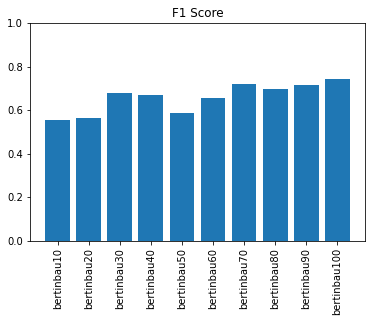

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.43584567070435165, 0.45110732538330495, 0.5831759084342705, 0.5749945259470112, 0.4778173774118225, 0.5518816619534479, 0.6309696092619391, 0.6202947725585833, 0.6311845730027549, 0.6704972375690608]


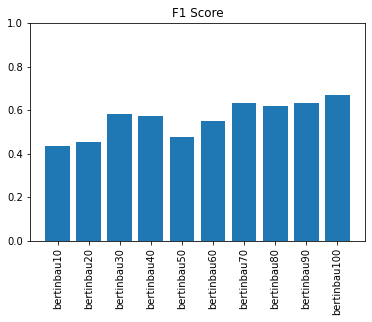

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['strict']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.6200089726334679, 0.6505394662123795, 0.7578619846649627, 0.7365885701773593, 0.6651099913973209, 0.7309114639982598, 0.7914950461983749, 0.7555932562824728, 0.7792837465564739, 0.8072928176795581]


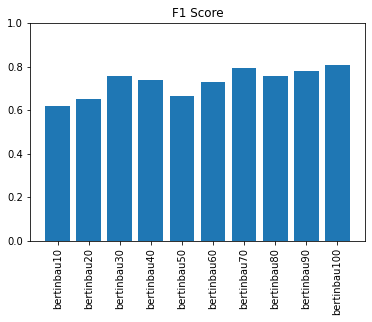

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['ent_type']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.4537909376401974, 0.4572402044293015, 0.5869541060117791, 0.5826582001313773, 0.4876490106919012, 0.5616706547748532, 0.6345318935767561, 0.6232637048033082, 0.634931129476584, 0.6727071823204419]


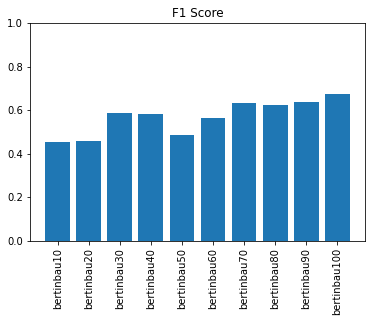

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['exact']['f1'] for x in xticks]
print(y)

fig, ax = plt.subplots(1, 1)
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

### test 2


['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[0.4433734939759036, 0.4615881213686249, 0.7626774847870182, 0.767741935483871, 0.9068150208623088, 0.3227684346701164, 0.9439890710382514, 0.722662440570523, 0.5185185185185185, 0.6903914590747332, 0.22596548890714874, 0.430622009569378, 0.4427020506634499, 0.7406639004149378, 0.7981072555205048, 0.9015256588072121, 0.3724035608308605, 0.7126436781609196, 0.7471999999999999, 0.6382113821138211, 0.832000

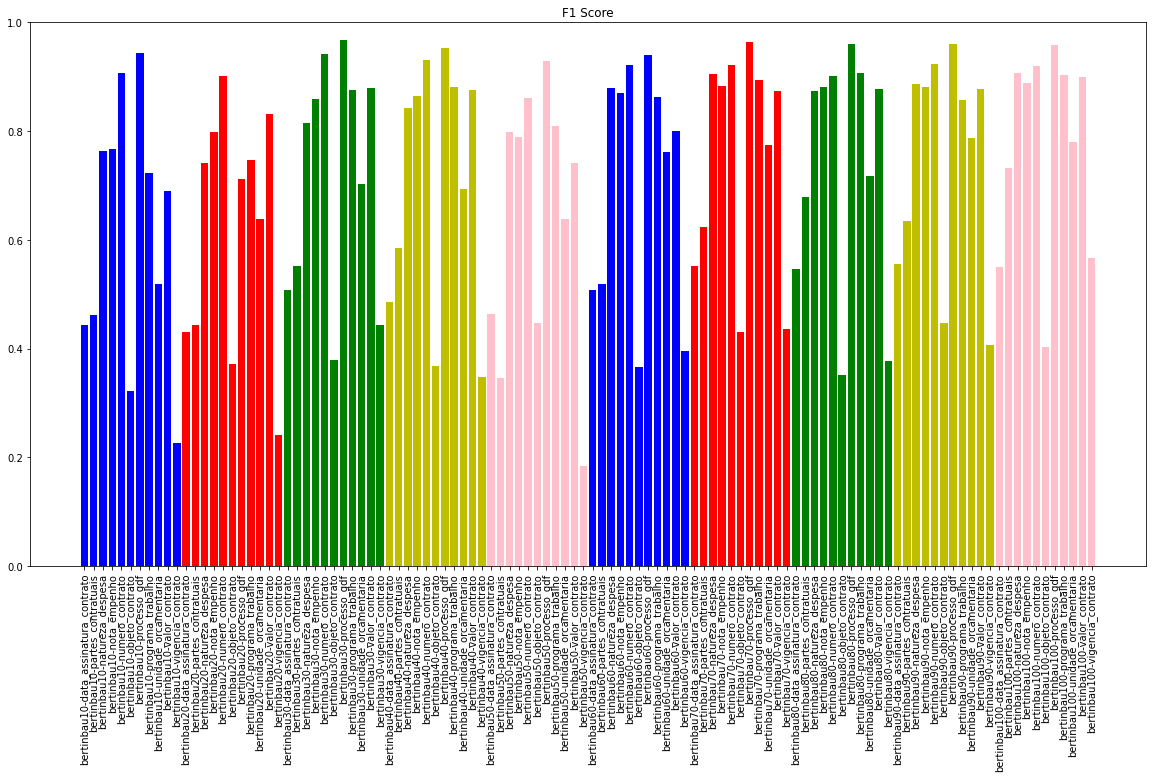

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11 + ['b']*11 +['r']*11 +['g']*11 +['y']*11 + ['pink']*11

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")

plt.show()

['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
[0.4433734939759036, 0.4615881213686249, 0.7626774847870182, 0.767741935483871, 0.9068150208623088, 0.3227684346701164, 0.9439890710382514, 0.722662440570523, 0.5185185185185185, 0.6903914590747332, 0.22596548890714874, 0.430622009569378, 0.4427020506634499, 0.7406639004149378, 0.7981072555205048, 0.9015256588072121, 0.3724035608308605, 0.7126436781609196, 0.7471999999999999, 0.6382113821138211, 0.832000

Text(0.5, 1.0, 'F1 Score')

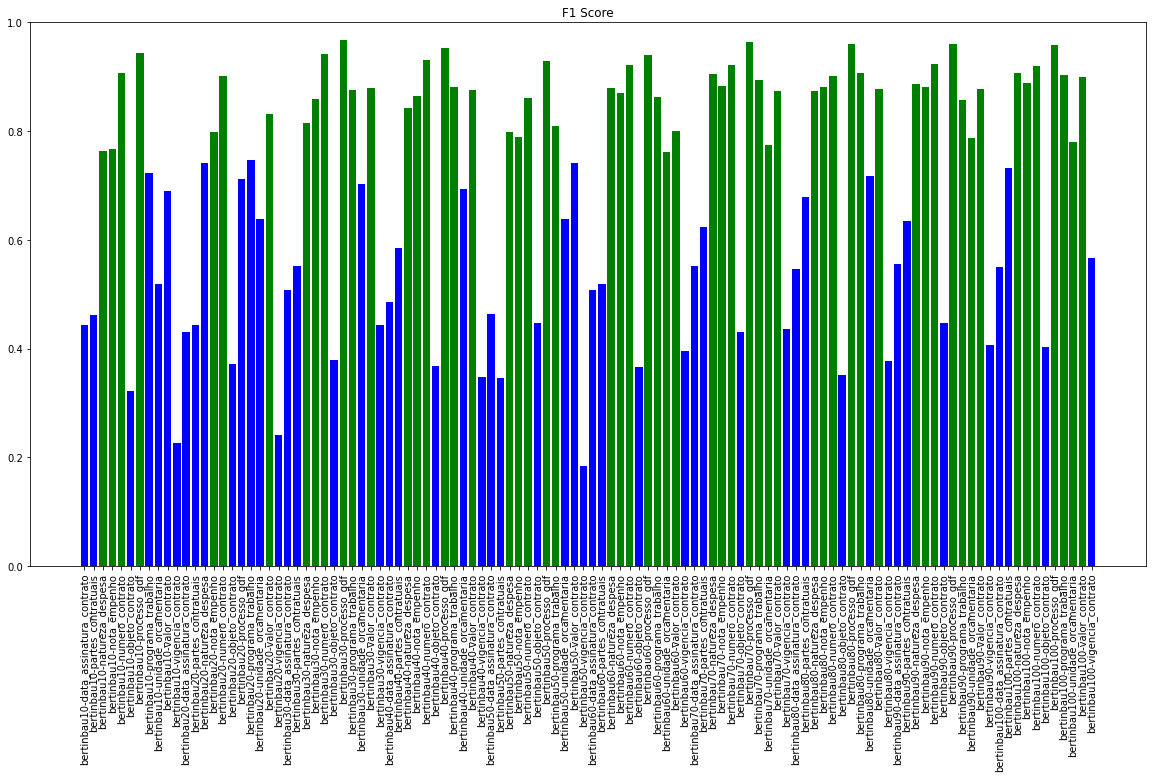

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks) * len(entidadesExtratoContrato)))
print(x)
y = [metrics[x][1][ent]['partial']['f1'] for x in xticks for ent in entidadesExtratoContrato]
print(y)

labels = [i+'-'+j for i in xticks for j in entidadesExtratoContrato]

colors = ['b']*110

l_best = []
for i in range(len(y)):
  if y[i]>0.75:
    colors[i]='g'
    l_best.append(labels[i])
print(l_best)

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
ax.bar(x, y, color = colors)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")


['bertinbau10', 'bertinbau20', 'bertinbau30', 'bertinbau40', 'bertinbau50', 'bertinbau60', 'bertinbau70', 'bertinbau80', 'bertinbau90', 'bertinbau100']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0.5536114849708389, 0.5624077228847245, 0.6776308478719858, 0.6699146047733743, 0.5884232518127074, 0.6560800522079617, 0.718913503283981, 0.6956844449157036, 0.7132782369146006, 0.7451933701657458]


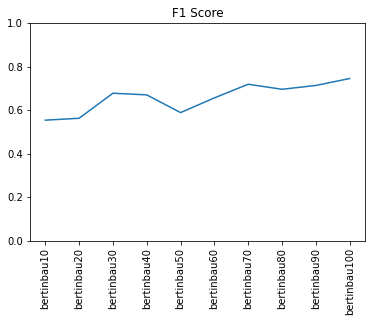

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['partial']['f1'] for x in xticks]
print(y)


fig, ax = plt.subplots(1, 1)
ax.plot(y) # adincionar linha
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
xticks = list(metrics.keys())
print(xticks)
x = list(range(len(xticks)))
print(x)
y = [metrics[x][0]['strict']['f1'] for x in xticks]
print(y)


fig, ax = plt.subplots(1, 1)
ax.plot(y) # adincionar linha
ax.set_xticks(x)
ax.set_xticklabels(xticks, rotation='vertical')
plt.ylim([0.0, 1])
plt.title("F1 Score")
plt.show()